Some signal-to-noise ratio plots for the CASTOR thingie.

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

from astropy.io import fits
import math

machine = 'coho'

In [7]:
plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

TINY_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
def CASTOR(CMOS=False, Dragonfly=False):
    area_lens = np.pi * (100./2.)**2 * u.cm**2                   # 1m circular aperture
    pix_size = 1.                                              # arcsec (total guess)
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2  # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    
    if CMOS:
        print "VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)"
        QE = 0.70                # quantum efficiency of the CMOS detector
        R = 2.                   # read noise (electrons)
    elif Dragonfly:
        print "VERBOSE: Using old cameras... (QE = 0.48, R = 10.)"
        QE = 0.48                # quantum efficiency of the CCDs
        R = 10.                  # read noise (electrons)
    else:
        print "VERBOSE: Guessing... (QE = 0.7, R = 5.)"
        QE = 0.7                # quantum efficiency of the CCDs
        R = 5.                  # read noise (electrons)
        
        
    R_squared = R**2 * u.photon
        
    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared]

[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = CASTOR()
print R_squared

VERBOSE: Guessing... (QE = 0.7, R = 5.)
25.0 ph


In [49]:
def print_verbose_string(printthis,verbose):
    if verbose:
        print printthis

def calcSNR(SB_ph,time,R_squared,D,explength=10.*(60.*u.second),verbose=False):
    numexp=1
    if isinstance(time.value, (np.ndarray)):
        numexp = np.array([math.ceil(thistime/explength) for thistime in time])
    else:
        numexp = math.ceil(time/explength) # round up the number of exposures
    print_verbose_string('Number of exposures: %s'%numexp,verbose)
        
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    ###B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    print_verbose_string('total S: %s'%signal,verbose)
    ###print('total B: %s'%(B_tot*time*numpixel))
    #sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)
    ###sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel*numlens + R_squared*numpixel*numlens*numexp)
    sigma = np.sqrt(signal + D*time*numpixel + R_squared*numpixel*numexp)
    print_verbose_string('total R: %s'%(R_squared*numpixel*numexp),verbose)
    print_verbose_string('total D: %s'%(D*time*numpixel),verbose)
    SNR = signal/sigma
    return SNR

In [39]:
def plotSNR(SB_ph,time,R_squared,D,refSNR=5.0,linestyle='-',label='',colour='black'):
    SNR = calcSNR(SB_ph,time,R_squared,D,explength=10.*(60.*u.second))
    ind = (np.abs(SNR.value-refSNR)).argmin()
    plt.plot(time/3600.,SNR,label=label+' (%.1f hr)'%(time[ind]/3600.).value,\
             linewidth=3,linestyle=linestyle,color=colour)
    return SNR,ind,time[ind]/3600.

In [40]:
SB_ph_min2 = 10**-2. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_min1 = 10**-1. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_0 = 10**0. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_1 = 10**1. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_2 = 10**2. * u.photon / (u.cm**2 * u.rad**2 * u.second)
SB_ph_3 = 10**3. * u.photon / (u.cm**2 * u.rad**2 * u.second)

In [41]:
sky_background = 0 *u.photon/u.second/u.arcsec**2/u.m**2 

In [69]:
numpixel = 100.0 * 100.0/(pix_size**2)   # 100-arcsec-a-side pixels
#numpixel = 200.0 * 200.0/(pix_size**2)   # 100-arcsec-a-side pixels
#numpixel = 1000.0 * 1000.0/(pix_size**2)   # 100-arcsec-a-side pixels

In [70]:
time = 60.*60.*1. * u.second
#print isinstance(time.value, (np.ndarray))
D = 0.001 *u.photon/u.second             # dark current (electrons / s) -- PER PIXEL??
R_squared = 1.**2 * u.photon
verbose=True
SNR = calcSNR(SB_ph_3,60.*60.*1. * u.second,R_squared,D,verbose=verbose)
print SNR
print ""
SNR = calcSNR(SB_ph_3,60.*60.*10. * u.second,R_squared,D,verbose=verbose)
print SNR
print ""
SNR = calcSNR(SB_ph_3,60.*60.*100. * u.second,R_squared,D,verbose=verbose)
print SNR
print ""
SNR = calcSNR(SB_ph_3,60.*60.*1000. * u.second,R_squared,D,verbose=verbose)
print SNR
print ""
#time = 60.*60.*60. * u.second
#SNR = calcSNR(SB_ph_three,time,R_squared,D)
#print SNR
#print ""

#time = 60.*60.*1. * u.second
#SNR = calcSNR(SB_ph_three,time,R_squared,D,explength=10.*(60.*u.second))
#print SNR

Number of exposures: 6.0
total S: 3954.19666614 ph
total R: 60000.0 ph
total D: 36000.0 ph
12.5071324511 ph(1/2)

Number of exposures: 60.0
total S: 39541.9666614 ph
total R: 600000.0 ph
total D: 360000.0 ph
39.551025543 ph(1/2)

Number of exposures: 600.0
total S: 395419.666614 ph
total R: 6000000.0 ph
total D: 3600000.0 ph
125.071324511 ph(1/2)

Number of exposures: 6000.0
total S: 3954196.66614 ph
total R: 60000000.0 ph
total D: 36000000.0 ph
395.51025543 ph(1/2)



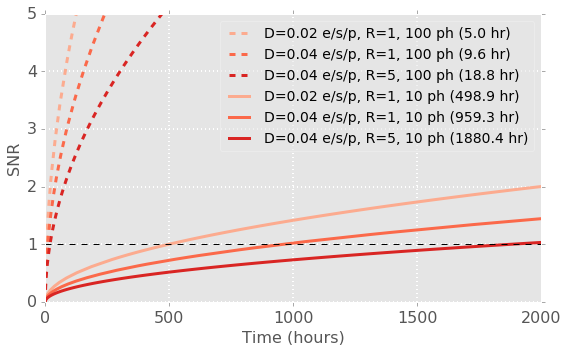

In [83]:
time = np.arange(1,60.*60.*2000.,60.*5)* u.second
limit = time[-1]/u.second

# reference signal-to-noise for comparison
refSNR = 1.0

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")

plt.figure(figsize=(8,5))

D = 0.02 *u.photon/u.second             # dark current (electrons / s) -- PER PIXEL??
R_squared = 1.**2 * u.photon
#SNR,ind,total = plotSNR(SB_ph_3,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1000 ph',colour=reds(0.3))
SNR,ind,total = plotSNR(SB_ph_2,time,R_squared,D,refSNR=refSNR,linestyle='--',
                        label='D=0.02 e/s/p, R=1, 100 ph',colour=reds(0.3))
#SNR,ind,total = plotSNR(SB_ph_1,time,R_squared,D,refSNR=refSNR,linestyle='-',
#                        label='D=0.02 e/s/p, R=1, 10 ph',colour=reds(0.3))
#SNR,ind,total = plotSNR(SB_ph_0,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1 ph',colour=reds(0.9))

D = 0.04 *u.photon/u.second             # dark current (electrons / s) -- PER PIXEL??
R_squared = 1.**2 * u.photon
#SNR,ind,total = plotSNR(SB_ph_3,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1000 ph',colour=reds(0.3))
SNR,ind,total = plotSNR(SB_ph_2,time,R_squared,D,refSNR=refSNR,linestyle='--',
                        label='D=0.04 e/s/p, R=1, 100 ph',colour=reds(0.5))
#SNR,ind,total = plotSNR(SB_ph_1,time,R_squared,D,refSNR=refSNR,linestyle='-',
#                        label='D=0.04 e/s/p, R=1, 10 ph',colour=reds(0.5))
#SNR,ind,total = plotSNR(SB_ph_0,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1 ph',colour=reds(0.9))

D = 0.04 *u.photon/u.second             # dark current (electrons / s) -- PER PIXEL??
R_squared = 5.**2 * u.photon
#SNR,ind,total = plotSNR(SB_ph_3,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1000 ph',colour=reds(0.3))
SNR,ind,total = plotSNR(SB_ph_2,time,R_squared,D,refSNR=refSNR,linestyle='--',
                        label='D=0.04 e/s/p, R=5, 100 ph',colour=reds(0.7))
#SNR,ind,total = plotSNR(SB_ph_1,time,R_squared,D,refSNR=refSNR,linestyle='-',
#                        label='D=0.04 e/s/p, R=5, 10 ph',colour=reds(0.7))
#SNR,ind,total = plotSNR(SB_ph_0,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1 ph',colour=reds(0.9))

D = 0.02 *u.photon/u.second             # dark current (electrons / s) -- PER PIXEL??
R_squared = 1.**2 * u.photon
#SNR,ind,total = plotSNR(SB_ph_3,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1000 ph',colour=reds(0.3))
#SNR,ind,total = plotSNR(SB_ph_2,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='D=0.02 e/s/p, R=1, 100 ph',colour=reds(0.3))
SNR,ind,total = plotSNR(SB_ph_1,time,R_squared,D,refSNR=refSNR,linestyle='-',
                        label='D=0.02 e/s/p, R=1, 10 ph',colour=reds(0.3))
#SNR,ind,total = plotSNR(SB_ph_0,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1 ph',colour=reds(0.9))

D = 0.04 *u.photon/u.second             # dark current (electrons / s) -- PER PIXEL??
R_squared = 1.**2 * u.photon
#SNR,ind,total = plotSNR(SB_ph_3,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1000 ph',colour=reds(0.3))
#SNR,ind,total = plotSNR(SB_ph_2,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='D=0.04 e/s/p, R=1, 100 ph',colour=reds(0.5))
SNR,ind,total = plotSNR(SB_ph_1,time,R_squared,D,refSNR=refSNR,linestyle='-',
                        label='D=0.04 e/s/p, R=1, 10 ph',colour=reds(0.5))
#SNR,ind,total = plotSNR(SB_ph_0,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1 ph',colour=reds(0.9))

D = 0.04 *u.photon/u.second             # dark current (electrons / s) -- PER PIXEL??
R_squared = 5.**2 * u.photon
#SNR,ind,total = plotSNR(SB_ph_3,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1000 ph',colour=reds(0.3))
#SNR,ind,total = plotSNR(SB_ph_2,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='D=0.04 e/s/p, R=5, 100 ph',colour=reds(0.7))
SNR,ind,total = plotSNR(SB_ph_1,time,R_squared,D,refSNR=refSNR,linestyle='-',
                        label='D=0.04 e/s/p, R=5, 10 ph',colour=reds(0.7))
#SNR,ind,total = plotSNR(SB_ph_0,time,R_squared,D,refSNR=refSNR,linestyle='--',
#                        label='1 ph',colour=reds(0.9))



plt.plot([0,limit/3600.],[refSNR,refSNR],'k--')   
plt.xlabel('Time (hours)')
plt.ylabel('SNR')
#plt.title('Comparing Filter Bandwidths (near 656.3nm)')
plt.grid(linestyle=':',linewidth=2)
plt.legend(loc=1,fancybox=True, framealpha=0.5)

loglog=False
loglogind=''
if loglog:
    plt.yscale('log')
    plt.xscale('log')
    loglogind='_loglog'
else:
    plt.xlim(0,limit/3600.)
    plt.ylim(0,5)

plt.tight_layout()
plt.savefig('SignalToNoise_CASTOR.pdf')

Make more sense to zoom in a lot on a filament and then say like half the field would be dominated by filament, so can stack all those pixels together (for the detection of filaments in between galaxies).